In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import cvxpy as cp

import torch
from torch import nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import DataLoader
import torch.optim as optim
import os
import random

import sys
sys.path.insert(0, './mlopt-micp')
sys.path.insert(0, './mlopt-micp/cartpole')

import optimizer
from problem import Cartpole
from src.ae import Encoder, get_cartpole_encoder

In [3]:
def euclidean_dist(x,y):
    # x: NxD
    # y: MxD
    n = x.size(0)
    m = y.size(0)
    d = x.size(1)
    assert d == y.size(1)
    
    x = x.unsqueeze(1).expand(n, m, d)
    y = y.unsqueeze(0).expand(n, m, d)
    return torch.pow(x-y, 2).sum(2)

In [4]:
pp = Cartpole()

In [5]:
print('Total number of classes: {}'.format(pp.n_strategies))
print('Length of feature vector: {}'.format(pp.n_features))

Total number of classes: 581
Length of feature vector: 13


In [89]:
dim_in, dim_z = pp.n_features, 2

enc = get_cartpole_encoder(dim_in, dim_z).cuda()
enc(torch.from_numpy(pp.features[:2]).float().cuda())

# training parameters
TRAINING_ITERATIONS = int(5000)
BATCH_SIZE = int(64)
CHECKPOINT_AFTER = int(1250)
SAVEPOINT_AFTER = int(2500)

rand_idx = list(np.arange(0, pp.n_strategies-1))

indices = [rand_idx[ii * BATCH_SIZE:(ii + 1) * BATCH_SIZE] for ii in range((len(rand_idx) + BATCH_SIZE - 1) // BATCH_SIZE)]
random.shuffle(indices)

enc_dict = {}
str_dict = {}
for ii in range(len(pp.features)):
    str_idx = int(pp.labels[ii,0])
    str_dict[ii] = str_idx
    if str_idx in enc_dict.keys():
        enc_dict[str_idx] += [ii]
    else:
        enc_dict[str_idx] = [ii]
        
feats = torch.from_numpy(pp.features).float().cuda()
#center and normalize data
feats = (feats-torch.mean(feats,dim=1,keepdim=True))/torch.sqrt(torch.var(feats,dim=1,keepdim=True))
strat_slices = tuple(enc_dict.values())

In [9]:
torch.cuda.empty_cache()
train_inds= int(pp.training_batch_percentage*pp.n_probs)
n = BATCH_SIZE; d = dim_z
m = pp.n_strategies
#for tt in range(training_iters):
#compute centroids
embeds = enc(feats)
centroids = torch.zeros(m,dim_z).cuda()
for ii in range(m):
    centroids[ii,:] = torch.mean(embeds[enc_dict[ii],:])
    
#n,d = embeds[batch_inds,:].shape
#m = centroids.size(0)

batch_inds = np.random.randint(0, train_inds,BATCH_SIZE)
diff = embeds[batch_inds,:].unsqueeze(1).expand(n,m,d) - centroids.unsqueeze(0).expand(n,m,d)
l2_dist = torch.norm(diff,dim=-1); l1_dist = torch.norm(diff,p=1,dim=-1)

dists = torch.where(l2_dist <= 1., l2_dist, l1_dist)

# #sample training points
# batch_inds = np.random.randint(0, train_inds,BATCH_SIZE)
# dists = torch.cdist(embeds[batch_inds,:],centroids)
margins = dists[torch.arange(BATCH_SIZE),pp.labels[batch_inds,0].astype(int)][:,None]
loss_mask = torch.zeros(BATCH_SIZE,m).cuda()
loss_mask[torch.arange(BATCH_SIZE),pp.labels[batch_inds,0].astype(int)] = -1.
losses = margins + torch.sum(torch.max(margins-dists+1,torch.zeros(1).cuda()),dim=1)[:,None]

#np.mean(np.equal(torch.argmin(dists,axis=1).cpu().numpy(),pp.labels[batch_inds,0].astype(int)))

#torch.sum(torch.max(loss_mask+margins-dists+1,torch.zeros(1).cuda()),dim=1)[:,None]

RuntimeError: CUDA out of memory. Tried to allocate 44.00 MiB (GPU 0; 1.95 GiB total capacity; 314.18 MiB already allocated; 18.62 MiB free; 332.00 MiB reserved in total by PyTorch)

In [97]:
optimizer = optim.Adam(enc.parameters(),lr=1e-3)
#N = pp.n_strategies # number of classes in training set
Nc = 100 # number of classes per episode
Ns = 20  # number of support examples per class
Nq = 20  # number of query examples per class
BATCH_SIZE = int(10000)
training_iters = 10000
n = BATCH_SIZE; d = dim_z
m = pp.n_strategies
centroids = 10*torch.randn(m,dim_z).cuda()
tau = 1.
train_inds = []
max_inds = np.argsort(np.array([len(e) for e in enc_dict.values()]))[-m:]
loss = torch.nn.CrossEntropyLoss()

for ii in max_inds:
    train_inds += enc_dict[ii]
    
train_inds = np.array(train_inds)
for tt in range(training_iters):
    optimizer.zero_grad()

    #train_inds= int(pp.training_batch_percentage*pp.n_probs)
    
    #compute centroids
    embeds = enc(feats)
    c_curr = torch.zeros(m,dim_z).cuda()
    for ii, v in enumerate(max_inds):
        c_curr[ii,:] = torch.mean(embeds[enc_dict[v],:])
        
    centroids = c_curr
    #centroids = (1-tau)*centroids + tau*c_curr
    

    #sample training points
    #batch_inds = np.random.randint(0, train_inds,BATCH_SIZE)
    batch_inds = np.random.choice(train_inds,BATCH_SIZE)
    diff = embeds[batch_inds,:].unsqueeze(1).expand(n,m,d) - centroids.unsqueeze(0).expand(n,m,d)
    l2_dist = torch.norm(diff,dim=-1); l1_dist = torch.norm(diff,p=1,dim=-1)
    batch_labels = np.concatenate([np.argwhere(max_inds==pp.labels[ii,0].astype(int)) for ii in batch_inds]).flatten()

    #dists = torch.min(l2_dist,l1_dist)
    dists = l2_dist
    #dists = torch.cdist(embeds[batch_inds,:],centroids)
    margins = dists[torch.arange(BATCH_SIZE),batch_labels][:,None]
    
    #print(torch.exp(-dists).shape)
    #print(torch.sum(torch.exp(-dists),dim=1).shape)
    
    #probs = torch.exp(-dists)/torch.sum(torch.exp(-dists),dim=1)[:,None]
    #loss_mask = torch.zeros(BATCH_SIZE,m).cuda()
    #loss_mask[torch.arange(BATCH_SIZE),batch_labels] = -1.
    #losses = 0.5*margins + 0.5*torch.sum(torch.max(loss_mask+margins-dists+1.,torch.zeros(1).cuda()),dim=1)[:,None]
    a = torch.max(-dists,dim=1)[0][:,None]
    losses = margins + a + torch.log(torch.sum(torch.exp(-a-dists),dim=1))[:,None] #- torch.cdist(centroids,centroids)
    
    if tt % 50 == 0: #print for debug
        acc = np.mean(np.equal(torch.argmin(dists,axis=1).cpu().numpy(),batch_labels))
        print(acc,torch.mean(losses))
        #print(acc,loss(probs,torch.from_numpy(batch_labels).cuda()))
    
    #loss(probs,torch.from_numpy(batch_labels).cuda()).backward()
    (torch.mean(losses)).backward()
    #torch.nn.utils.clip_grad_norm_(enc.parameters(),0.01)
    
    #centroids = centroids.detach()
    optimizer.step()

0.624 tensor(1.2951, device='cuda:0', grad_fn=<MeanBackward0>)
0.6486 tensor(1.2539, device='cuda:0', grad_fn=<MeanBackward0>)
0.6454 tensor(1.2761, device='cuda:0', grad_fn=<MeanBackward0>)
0.6379 tensor(1.2725, device='cuda:0', grad_fn=<MeanBackward0>)
0.6413 tensor(1.2531, device='cuda:0', grad_fn=<MeanBackward0>)
0.642 tensor(1.2569, device='cuda:0', grad_fn=<MeanBackward0>)
0.6386 tensor(1.2738, device='cuda:0', grad_fn=<MeanBackward0>)
0.6388 tensor(1.2639, device='cuda:0', grad_fn=<MeanBackward0>)
0.6394 tensor(1.2755, device='cuda:0', grad_fn=<MeanBackward0>)
0.645 tensor(1.2561, device='cuda:0', grad_fn=<MeanBackward0>)
0.6437 tensor(1.2660, device='cuda:0', grad_fn=<MeanBackward0>)
0.6444 tensor(1.2594, device='cuda:0', grad_fn=<MeanBackward0>)


KeyboardInterrupt: 

In [73]:
## train linear embedding map (this is garbage)

#emb_mat = torch.autograd.Variable(torch.randn(dim_z,dim_in),requires_grad=True)

optimizer = optim.Adam([emb_mat],lr=1e-4)
#N = pp.n_strategies # number of classes in training set
Nc = 100 # number of classes per episode
Ns = 20  # number of support examples per class
Nq = 20  # number of query examples per class
BATCH_SIZE = int(1000)
training_iters = 10000
n = BATCH_SIZE; d = dim_z
m = 25
centroids = 10*torch.randn(m,dim_z).cuda()
tau = 1.
train_inds = []
max_inds = np.argsort(np.array([len(e) for e in enc_dict.values()]))[-m:]
loss = torch.nn.CrossEntropyLoss()

for ii in max_inds:
    train_inds += enc_dict[ii]
    
train_inds = np.array(train_inds)
for tt in range(training_iters):
    optimizer.zero_grad()

    #train_inds= int(pp.training_batch_percentage*pp.n_probs)
    
    #compute centroids
    embeds = torch.matmul(emb_mat.unsqueeze(0).cuda(),feats.unsqueeze(-1)).squeeze()
    c_curr = torch.zeros(m,dim_z).cuda()
    for ii, v in enumerate(max_inds):
        c_curr[ii,:] = torch.mean(embeds[enc_dict[v],:])
        
    centroids = c_curr
    #centroids = (1-tau)*centroids + tau*c_curr
    

    #sample training points
    #batch_inds = np.random.randint(0, train_inds,BATCH_SIZE)
    batch_inds = np.random.choice(train_inds,BATCH_SIZE)
    diff = embeds[batch_inds,:].unsqueeze(1).expand(n,m,d) - centroids.unsqueeze(0).expand(n,m,d)
    l2_dist = torch.norm(diff,dim=-1); l1_dist = torch.norm(diff,p=1,dim=-1)
    batch_labels = np.concatenate([np.argwhere(max_inds==pp.labels[ii,0].astype(int)) for ii in batch_inds]).flatten()

    #dists = torch.min(l2_dist,l1_dist)
    dists = l2_dist
    #dists = torch.cdist(embeds[batch_inds,:],centroids)
    margins = dists[torch.arange(BATCH_SIZE),batch_labels][:,None]
    
    #print(torch.exp(-dists).shape)
    #print(torch.sum(torch.exp(-dists),dim=1).shape)
    
    #probs = torch.exp(-dists)/torch.sum(torch.exp(-dists),dim=1)[:,None]
    #loss_mask = torch.zeros(BATCH_SIZE,m).cuda()
    #loss_mask[torch.arange(BATCH_SIZE),batch_labels] = -1.
    #losses = 0.5*margins + 0.5*torch.sum(torch.max(loss_mask+margins-dists+1.,torch.zeros(1).cuda()),dim=1)[:,None]
    a = torch.max(-dists,dim=1)[0][:,None]
    losses = margins + a + torch.log(torch.sum(torch.exp(-a-dists),dim=1))[:,None] #- torch.cdist(centroids,centroids)
    
    if tt % 50 == 0: #print for debug
        acc = np.mean(np.equal(torch.argmin(dists,axis=1).cpu().numpy(),batch_labels))
        print(acc,torch.mean(losses))
        #print(acc,loss(probs,torch.from_numpy(batch_labels).cuda()))
    
    #loss(probs,torch.from_numpy(batch_labels).cuda()).backward()
    (torch.mean(losses)).backward()
    #torch.nn.utils.clip_grad_norm_(enc.parameters(),0.01)
    
    #centroids = centroids.detach()
    optimizer.step()

0.275 tensor(2.3377, device='cuda:0', grad_fn=<MeanBackward0>)
0.297 tensor(2.3327, device='cuda:0', grad_fn=<MeanBackward0>)
0.298 tensor(2.3292, device='cuda:0', grad_fn=<MeanBackward0>)
0.264 tensor(2.3232, device='cuda:0', grad_fn=<MeanBackward0>)
0.274 tensor(2.3388, device='cuda:0', grad_fn=<MeanBackward0>)
0.265 tensor(2.3576, device='cuda:0', grad_fn=<MeanBackward0>)
0.281 tensor(2.3184, device='cuda:0', grad_fn=<MeanBackward0>)
0.265 tensor(2.3540, device='cuda:0', grad_fn=<MeanBackward0>)
0.262 tensor(2.3745, device='cuda:0', grad_fn=<MeanBackward0>)
0.269 tensor(2.3124, device='cuda:0', grad_fn=<MeanBackward0>)
0.261 tensor(2.3705, device='cuda:0', grad_fn=<MeanBackward0>)
0.292 tensor(2.3417, device='cuda:0', grad_fn=<MeanBackward0>)
0.263 tensor(2.3427, device='cuda:0', grad_fn=<MeanBackward0>)
0.266 tensor(2.3529, device='cuda:0', grad_fn=<MeanBackward0>)
0.268 tensor(2.3466, device='cuda:0', grad_fn=<MeanBackward0>)
0.271 tensor(2.3449, device='cuda:0', grad_fn=<MeanBack

KeyboardInterrupt: 

In [98]:
#test script
n_train_strategies = m #store how many strats in train set
c_k = torch.zeros((n_train_strategies,dim_z))

embeddings = enc(feats) #embed training points
for ii in range(n_train_strategies): #compute train centroids
    inds = enc_dict[max_inds[ii]]
    c_k[ii,:] = torch.mean(embeddings[inds,:],axis=0).cuda()

#compute strategy dictionary for all problems
pp.training_batch_percentage = 1.
pp.construct_strategies()
strat_lookup = {}
for k, v in pp.strategy_dict.items():
    strat_lookup[v[0]] = v[1:]

#setup for test
test_feats = torch.from_numpy(pp.features[int(0.9*pp.n_probs):,:]).float().cuda()
test_feats = (test_feats-torch.mean(test_feats,dim=1,keepdim=True))/torch.sqrt(torch.var(test_feats,dim=1,keepdim=True))
test_enc = enc(test_feats).cuda()
test_dists = torch.cdist(test_enc,c_k.cuda()).detach().cpu().numpy()
test_start = int(0.9*pp.n_probs)
n_test = int(0.1*pp.n_probs)
ind_max = np.argsort(test_dists)[:,:pp.n_evals]
feasible = np.zeros(n_test)
costs = np.zeros(n_test)

In [99]:
prob_success = False

for ii in range(n_test):
    for jj in range(pp.n_evals):
        y_guess = strat_lookup[max_inds[ind_max[ii,jj]]]
        try:
            prob_success, cost, solve_time = pp.solve_mlopt_prob_with_idx(ii+test_start, y_guess)
            if prob_success:
                feasible[ii] = 1.
                costs[ii] = cost
                print('Succeded at {} with {} tries'.format(ii,jj+1))
                break
        except (KeyboardInterrupt, SystemExit):
            raise
        except:
            print('mosek failed at '.format(ii))

Succeded at 0 with 8 tries
Succeded at 1 with 1 tries
Succeded at 2 with 1 tries
Succeded at 3 with 1 tries
Succeded at 4 with 1 tries
Succeded at 6 with 1 tries
Succeded at 7 with 5 tries
Succeded at 8 with 1 tries
Succeded at 9 with 3 tries
Succeded at 11 with 1 tries
Succeded at 12 with 1 tries
Succeded at 13 with 1 tries
Succeded at 14 with 2 tries
Succeded at 15 with 2 tries
Succeded at 16 with 1 tries
Succeded at 17 with 1 tries
Succeded at 18 with 1 tries
Succeded at 19 with 1 tries
Succeded at 20 with 1 tries
Succeded at 23 with 1 tries
Succeded at 24 with 1 tries
Succeded at 26 with 1 tries
Succeded at 27 with 1 tries
Succeded at 28 with 1 tries
Succeded at 29 with 1 tries
Succeded at 30 with 1 tries
Succeded at 32 with 1 tries
Succeded at 33 with 1 tries
Succeded at 34 with 3 tries
Succeded at 35 with 6 tries
Succeded at 36 with 1 tries
Succeded at 37 with 1 tries
Succeded at 38 with 8 tries
Succeded at 39 with 1 tries
Succeded at 40 with 1 tries
Succeded at 41 with 1 tries
S

KeyboardInterrupt: 

In [100]:
fn_classifier_model = f'pytorch/coco-{m}strats.pt'
# Save model
if not os.path.exists('pytorch'):
    os.makedirs('pytorch')
torch.save(enc.state_dict(), fn_classifier_model)

In [101]:
np.mean(feasible[:ii])

0.9387755102040817

Using scipy.spatial.voronoi_plot_2d, wait...


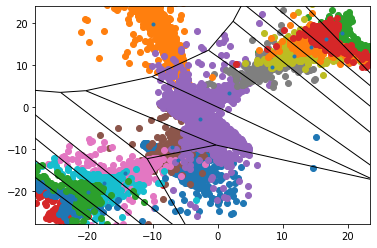

In [109]:
import scipy
from scipy.spatial import Voronoi, voronoi_plot_2d, KDTree
import matplotlib.pyplot as plt

n_train_strategies = pp.n_strategies #store how many strats in train set
c_k = torch.zeros((n_train_strategies,dim_z)) 
embeddings = enc(feats) #embed training points
#embeddings = torch.matmul(emb_mat.unsqueeze(0).cuda(),feats.unsqueeze(-1)).squeeze()
for ii in range(m): #compute train centroids
    inds = enc_dict[ii]
    c_k[ii,:] = torch.mean(embeddings[inds,:],axis=0).cuda()

num_points = 15

max_inds = np.argsort(np.array([len(e) for e in enc_dict.values()]))[-num_points:]

points = c_k[max_inds,:].detach().numpy()

vor = Voronoi(points)
x = np.linspace(0, 1, 200)
y = np.linspace(0, 1, 200)
xx, yy = np.meshgrid(x, y)
xy = np.c_[xx.ravel(), yy.ravel()]

#print(vor.ridge_points)

print('Using scipy.spatial.voronoi_plot_2d, wait...')
voronoi_plot_2d(vor,show_vertices=False)

for ii in max_inds:
    embs = embeddings[enc_dict[ii],:].cpu().detach().numpy()
    plt.scatter(embs[:,0],embs[:,1])
#save_fig('knnVoronoiMesh.pdf')
plt.show()

#print('Using scipy.spatial.KDTree, wait a few seconds...')
#plt.figure()
#plt.plot(points[:, 0], points[:, 1], 'ko')
#plt.pcolormesh(x, y, tree.query(xy)[1].reshape(200,200), cmap='jet')

#enc_dict[0]